In [443]:
# Se importan las librerías a utilizar en todo el proyecto

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectPercentile, mutual_info_classif, chi2, f_classif

from termcolor import colored
from joblib import dump # Permite guardar el estandarizador 

# Se requiere la instalación en el equipo del la librería "imblearn". (pip install imbalanced-learn)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

## 1. Selección de datos

In [431]:
# Se carga el Dataframe preparado en la etapa de Análisis con información del estudiante

students = pd.read_csv('res/df_students.csv', sep=';')
del students['Unnamed: 0']
del students['num_of_prev_attempts']
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27912 entries, 0 to 27911
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   code_module        27912 non-null  int64
 1   code_presentation  27912 non-null  int64
 2   id_student         27912 non-null  int64
 3   gender             27912 non-null  int64
 4   region             27912 non-null  int64
 5   highest_education  27912 non-null  int64
 6   age_band           27912 non-null  int64
 7   studied_credits    27912 non-null  int64
 8   disability         27912 non-null  int64
 9   final_result       27912 non-null  int64
dtypes: int64(10)
memory usage: 2.1 MB


In [432]:
# Se carga el Dataframe preparado en la etapa de Análisis con información del estudiante

studentsVle = pd.read_csv('res/df_studentsVle.csv', sep=';')
del studentsVle['Unnamed: 0']
studentsVle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9340634 entries, 0 to 9340633
Data columns (total 6 columns):
 #   Column             Dtype
---  ------             -----
 0   code_module        int64
 1   code_presentation  int64
 2   id_student         int64
 3   id_site            int64
 4   date               int64
 5   sum_click          int64
dtypes: int64(6)
memory usage: 427.6 MB


In [433]:
# Se contabiliza la actividad de cada estudiante por módulo por medio de la suma de clicks en cada actividad

columns_sel=['id_student', 'sum_click']
students_sum=studentsVle[columns_sel]
students_clicks = students_sum.groupby(['id_student']).count().reset_index()
display(students_clicks)

,id_student,sum_click
0,6516,548
1,8462,289
2,11391,155
3,23629,54
4,23698,290
...,...,...
26068,2698251,474
26069,2698257,247
26070,2698535,717
26071,2698577,214


In [434]:
students_combined = students_clicks.merge(students, on=['id_student'], how='inner') 
students_combined = students_combined.drop(students_combined[students_combined['final_result'] == '0'].index)
display(students_combined)

,id_student,sum_click,code_module,code_presentation,gender,region,highest_education,age_band,studied_credits,disability,final_result
0,6516,548,1,4,2,2,4,3,60,1,1
1,8462,289,4,2,2,13,4,3,90,1,0
2,23698,290,3,4,1,1,3,1,120,1,1
3,23798,297,2,2,2,6,3,1,60,1,1
4,24186,81,7,3,1,12,2,1,30,2,1
...,...,...,...,...,...,...,...,...,...,...,...
25477,2698257,247,1,2,2,11,2,1,120,1,1
25478,2698535,717,3,3,2,6,2,1,60,1,0
25479,2698535,717,5,2,2,6,2,1,60,1,1
25480,2698577,214,2,4,1,6,2,2,60,1,0


In [435]:
# tabla similar con las correlaciones más positivas (evitar parejas del mismo valor)
positive_corr = students_combined.drop(['id_student'],axis=1).corr(numeric_only=True)
np.fill_diagonal(positive_corr.values, 0)
positive_corr.idxmax()

sum_click               final_result
code_module                   gender
code_presentation             gender
gender                   code_module
region                   code_module
highest_education       final_result
age_band                   sum_click
studied_credits               gender
disability           studied_credits
final_result               sum_click
dtype: object

In [436]:
positive_corr.style.background_gradient(cmap=plt.get_cmap('RdYlGn'), axis=1, vmin=-1.0, vmax=1.0)

,sum_click,code_module,code_presentation,gender,region,highest_education,age_band,studied_credits,disability,final_result
sum_click,0.000000,0.081661,-0.011314,0.161340,-0.012924,0.120374,0.133592,0.032857,-0.023718,0.418390
code_module,0.081661,0.000000,-0.036713,0.251901,0.024939,-0.095371,-0.050721,-0.163474,0.027484,0.022381
code_presentation,-0.011314,-0.036713,0.000000,0.061235,-0.011615,0.035185,0.004667,-0.004905,-0.005727,0.001942
gender,0.161340,0.251901,0.061235,0.000000,-0.016717,0.060187,-0.035044,0.045438,-0.042572,-0.051777
region,-0.012924,0.024939,-0.011615,-0.016717,0.000000,-0.063657,-0.001171,0.019132,-0.034608,-0.005265
highest_education,0.120374,-0.095371,0.035185,0.060187,-0.063657,0.000000,0.083976,0.042556,-0.076018,0.134619
age_band,0.133592,-0.050721,0.004667,-0.035044,-0.001171,0.083976,0.000000,-0.087440,-0.027304,0.071878
studied_credits,0.032857,-0.163474,-0.004905,0.045438,0.019132,0.042556,-0.087440,0.000000,0.034787,-0.109509
disability,-0.023718,0.027484,-0.005727,-0.042572,-0.034608,-0.076018,-0.027304,0.034787,0.000000,-0.056561
final_result,0.418390,0.022381,0.001942,-0.051777,-0.005265,0.134619,0.071878,-0.109509,-0.056561,0.000000


In [437]:
# Se filtran los casos en los que el estudiante aprobó el curso

students_combined_fil = students_combined[students_combined['final_result']==1]
students_combined_fil.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13764 entries, 0 to 25481
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   id_student         13764 non-null  int64
 1   sum_click          13764 non-null  int64
 2   code_module        13764 non-null  int64
 3   code_presentation  13764 non-null  int64
 4   gender             13764 non-null  int64
 5   region             13764 non-null  int64
 6   highest_education  13764 non-null  int64
 7   age_band           13764 non-null  int64
 8   studied_credits    13764 non-null  int64
 9   disability         13764 non-null  int64
 10  final_result       13764 non-null  int64
dtypes: int64(11)
memory usage: 1.3 MB


In [438]:
# Se eliminan las columnas que no serán analizadas según el resultado de correlación y porque tienen el resultado

del students_combined_fil['id_student']
del students_combined_fil['disability']
del students_combined_fil['final_result']


# Se guarda un archivo con la información de los semestres para análisis de agrupamiento
ruta = os.path.join("res" ,"students_semester.csv")
students_combined_fil.to_csv(ruta, sep=';')

del students_combined_fil['code_presentation']
students_combined_fil.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13764 entries, 0 to 25481
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   sum_click          13764 non-null  int64
 1   code_module        13764 non-null  int64
 2   gender             13764 non-null  int64
 3   region             13764 non-null  int64
 4   highest_education  13764 non-null  int64
 5   age_band           13764 non-null  int64
 6   studied_credits    13764 non-null  int64
dtypes: int64(7)
memory usage: 860.2 KB


In [409]:
X = students_combined_fil.copy()
y = students_combined_fil['code_module']
del X['code_module']

In [410]:
#Estandarización de los datos 
from sklearn.preprocessing import StandardScaler
estandarizador = StandardScaler()
estandarizador.fit(X)

X_training_std = estandarizador.transform(X)

print(X[:1])
print(X_training_std[0])

   sum_click  gender  region  highest_education  age_band  studied_credits
0        548       2       2                  4         3               60
[ 0.00692809  0.9289893  -1.1759173   1.63513629  3.41166331 -0.34211526]


In [411]:
# Guardar el StandardScaler entrenado en un archivo
dump(estandarizador, 'scaler_courses.joblib')

['scaler_courses.joblib']

In [412]:

print(X[:1])
print(X_training_std[0])

   sum_click  gender  region  highest_education  age_band  studied_credits
0        548       2       2                  4         3               60
[ 0.00692809  0.9289893  -1.1759173   1.63513629  3.41166331 -0.34211526]


In [413]:
# tabla similar con las correlaciones más positivas (evitar parejas del mismo valor)
positive_corr = students_combined_fil.corr(numeric_only=True)
np.fill_diagonal(positive_corr.values, 0)
positive_corr.idxmax()
positive_corr.style.background_gradient(cmap=plt.get_cmap('RdYlGn'), axis=1, vmin=-1.0, vmax=1.0)

,sum_click,code_module,gender,region,highest_education,age_band,studied_credits
sum_click,0.000000,0.121705,0.252159,-0.007408,0.075344,0.121877,0.105716
code_module,0.121705,0.000000,0.252934,0.016907,-0.114259,-0.064464,-0.196240
gender,0.252159,0.252934,0.000000,-0.014191,0.074287,-0.037293,0.059795
region,-0.007408,0.016907,-0.014191,0.000000,-0.072084,-0.005501,0.016455
highest_education,0.075344,-0.114259,0.074287,-0.072084,0.000000,0.075883,0.081573
age_band,0.121877,-0.064464,-0.037293,-0.005501,0.075883,0.000000,-0.088987
studied_credits,0.105716,-0.196240,0.059795,0.016455,0.081573,-0.088987,0.000000


In [444]:
#Selección de atributos con Mutual information. SE ELIMINA LA EDAD (age_band)
print(students_combined_fil.shape)

selector = SelectPercentile(score_func=mutual_info_classif, percentile=90)
X_training_std_sel = selector.fit_transform(students_combined_fil, y)

print(X_training_std_sel.shape)
display(students_combined_fil.head(1))
print(X_training_std_sel[0])

(13764, 7)
(13764, 6)


,sum_click,code_module,gender,region,highest_education,age_band,studied_credits
0,548,1,2,2,4,3,60


[548   1   2   4   3  60]


In [442]:
#Selección de atributos con Chi2. SE ELIMINA LA EDAD (age_band)

print(students_combined_fil.shape)

selector = SelectPercentile(score_func=chi2, percentile=90)
X_training_std_sel = selector.fit_transform(students_combined_fil, y)

print(X_training_std_sel.shape)
display(students_combined_fil.head(1))
print(X_training_std_sel[0])

(13764, 7)
(13764, 6)


,sum_click,code_module,gender,region,highest_education,age_band,studied_credits
0,548,1,2,2,4,3,60


[548   1   2   2   4  60]


In [415]:
# Evaluación de atributos: F-Test.
f_test, p_value = f_classif(X_training_std, y) # Llamamos al estadístico F

# Definimos el valor de significancia (alpha)
alpha = 0.1

# Definimos la decisión de si aceptamos o rechazamos la hipótesis nula (Ho) para cada variable
for i in range(len(p_value)):
    p_val = p_value[i]
    
    if p_val<alpha:
        h = 1 # Se rechaza la hipótesis nula que defiende la independencia entre variables. Por tanto, DEPENDIENTES.
        print(colored('La variable ' + str(i) + ' es linealmente DEPENDIENTE de la clase. p-value: ' + str(p_val), 'green'))
    else:
        h = 0 # No hay evidencia estadística para rechazar la hipótesis nula, por tanto, se asume INDEPENDENCIA entre variables
        print(colored('La variable ' + str(i) + ' es linealmente INDEPENDIENTE de la clase. p-value: ' + str(p_val), 'red'))

La variable 0 es linealmente DEPENDIENTE de la clase. p-value: 0.0
La variable 1 es linealmente DEPENDIENTE de la clase. p-value: 0.0
La variable 2 es linealmente DEPENDIENTE de la clase. p-value: 4.896812087444331e-07
La variable 3 es linealmente DEPENDIENTE de la clase. p-value: 9.590023982596455e-159
La variable 4 es linealmente DEPENDIENTE de la clase. p-value: 1.8340321325376883e-65
La variable 5 es linealmente DEPENDIENTE de la clase. p-value: 0.0


## 2. Balanceo de datos

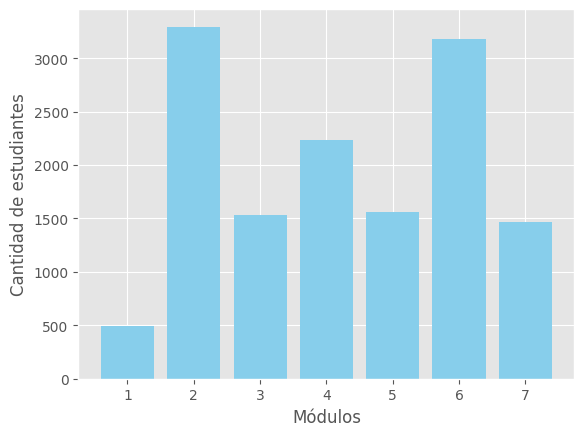

In [416]:
# Diagrama de barras para la variable code_module

modules, frec = np.unique(students_combined_fil['code_module'], return_counts=True)
plt.ylabel('Cantidad de estudiantes')
plt.xlabel('Módulos')
#plt.title('Estudiantes por módulo')
plt.bar(modules, frec, color='skyblue') 
plt.show()

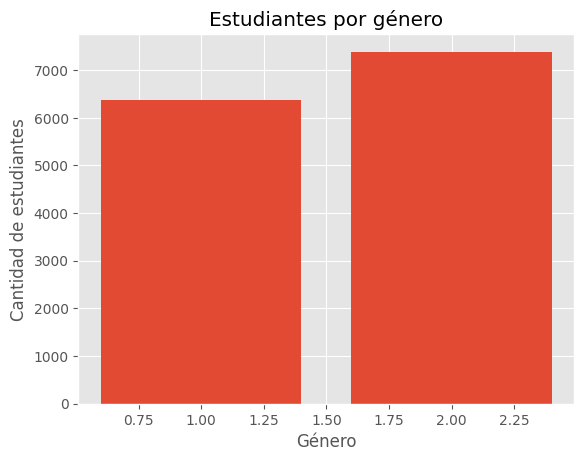

In [417]:
# Diagrama de barras para la variable gender

gen, frec = np.unique(students_combined_fil['gender'], return_counts=True)
plt.ylabel('Cantidad de estudiantes')
plt.xlabel('Género')
plt.title('Estudiantes por género')
plt.bar(gen, frec) 
plt.show()


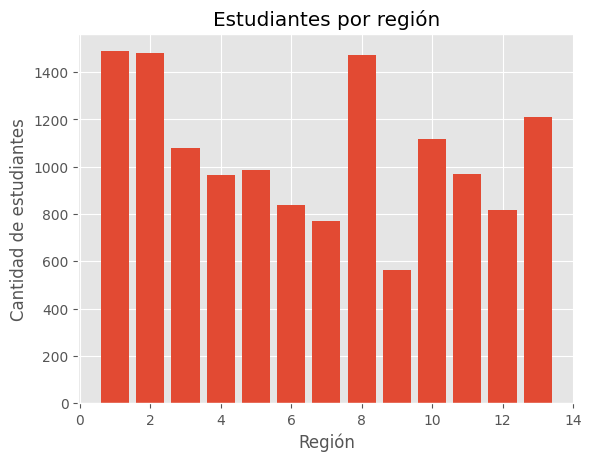

In [418]:
# Diagrama de barras para la variable region

reg, frec = np.unique(students_combined_fil['region'], return_counts=True)
plt.ylabel('Cantidad de estudiantes')
plt.xlabel('Región')
plt.title('Estudiantes por región')
plt.bar(reg, frec) 
plt.show()

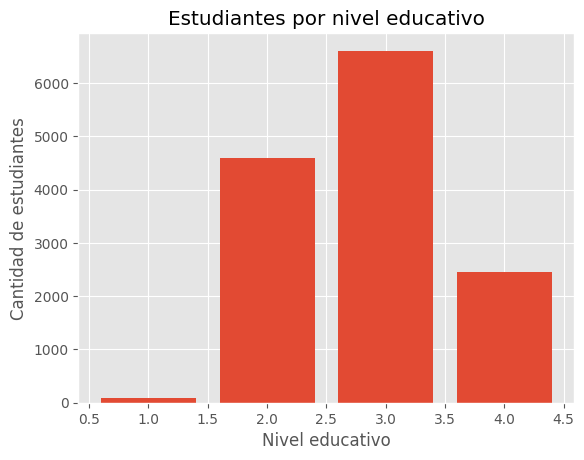

In [419]:
# Diagrama de barras para la variable highest_education

educ, frec = np.unique(students_combined_fil['highest_education'], return_counts=True)
plt.ylabel('Cantidad de estudiantes')
plt.xlabel('Nivel educativo')
plt.title('Estudiantes por nivel educativo')
plt.bar(educ, frec) 
plt.show()

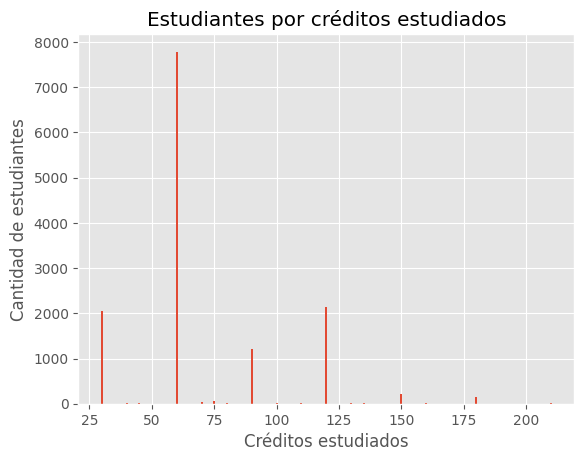

In [420]:
# Diagrama de barras para la variable studied_credits

cred, frec = np.unique(students_combined_fil['studied_credits'], return_counts=True)
plt.ylabel('Cantidad de estudiantes')
plt.xlabel('Créditos estudiados')
plt.title('Estudiantes por créditos estudiados')
plt.bar(cred, frec) 
plt.show()


In [421]:

# Aplicar RandomOverSampler para sobremuestrear la clase minoritaria
ros = RandomOverSampler(random_state=42)
#X_resampled, y_resampled = ros.fit_resample(X, y)(X_training_std, y)
X_resampled, y_resampled = ros.fit_resample(X_training_std_sel, y)

# Aplicar RandomUnderSampler para submuestrear la clase mayoritaria
rus = RandomUnderSampler(sampling_strategy='not majority',random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)

# Mostrar la distribución de clases después del balanceo
print("\nDistribución de clases después del balanceo:")
print(pd.Series(y_resampled).value_counts())


Distribución de clases después del balanceo:
code_module
1    3294
2    3294
3    3294
4    3294
5    3294
6    3294
7    3294
Name: count, dtype: int64


In [422]:
# Al realizar el balanceo se generaron muchas más muestras, pasando de 13764 a 23058

print(X_training_std_sel.shape)
print(X_resampled.shape)
print(type(X_resampled))

(13764, 5)
(23058, 5)
<class 'numpy.ndarray'>


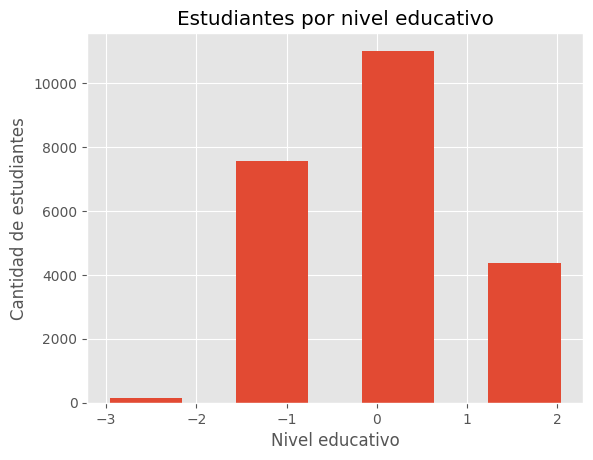

In [426]:
# Diagrama de barras para la variable code_module   
nom_columns = ['sum_click', 'gender', 'region', 'highest_education','studied_credits'] 
students_balanced = pd.DataFrame(X_resampled, columns=nom_columns)
students_balanced['code_module'] = y_resampled
#del students_balanced['age_band']

educ, frec = np.unique(students_balanced['highest_education'], return_counts=True)
plt.ylabel('Cantidad de estudiantes')
plt.xlabel('Nivel educativo')
plt.title('Estudiantes por nivel educativo')
plt.bar(educ, frec) 
plt.show()

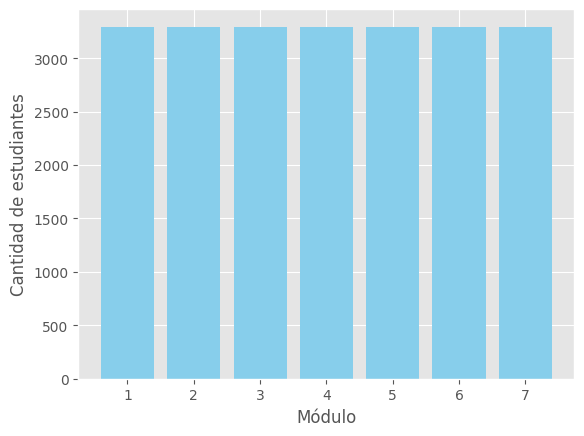

In [427]:
modules, frec = np.unique(students_balanced['code_module'], return_counts=True)
plt.ylabel('Cantidad de estudiantes')
plt.xlabel('Módulo')
#plt.title('Estudiantes por módulo')
plt.bar(modules, frec, color='skyblue') 
plt.show()

In [428]:
print(students_balanced.shape)

(23058, 6)


In [430]:
ruta = os.path.join("res" ,"students_balanced.csv")

students_balanced.to_csv(ruta, sep=';')